🚀 Starting Benchmark Analysis...
Loading tree benchmark data...
  ✓ Loaded benchmark_results_serial.csv: 24 rows
  ✓ Loaded benchmark_results_parallel_2threads.csv: 24 rows
  ✓ Loaded benchmark_results_parallel_4threads.csv: 24 rows
  ✓ Loaded benchmark_results_parallel_6threads.csv: 24 rows
  ✓ Loaded benchmark_results_parallel_8threads.csv: 24 rows

Loading cross-validation data...
  ✓ Loaded cv_results_serial.csv: 24 rows
  ✓ Loaded cv_results_parallel_2threads.csv: 24 rows
  ✓ Loaded cv_results_parallel_4threads.csv: 24 rows
  ✓ Loaded cv_results_parallel_6threads.csv: 24 rows
  ✓ Loaded cv_results_parallel_8threads.csv: 24 rows

✅ Loaded data for 5 tree configurations and 5 CV configurations

📊 Generating visualizations...


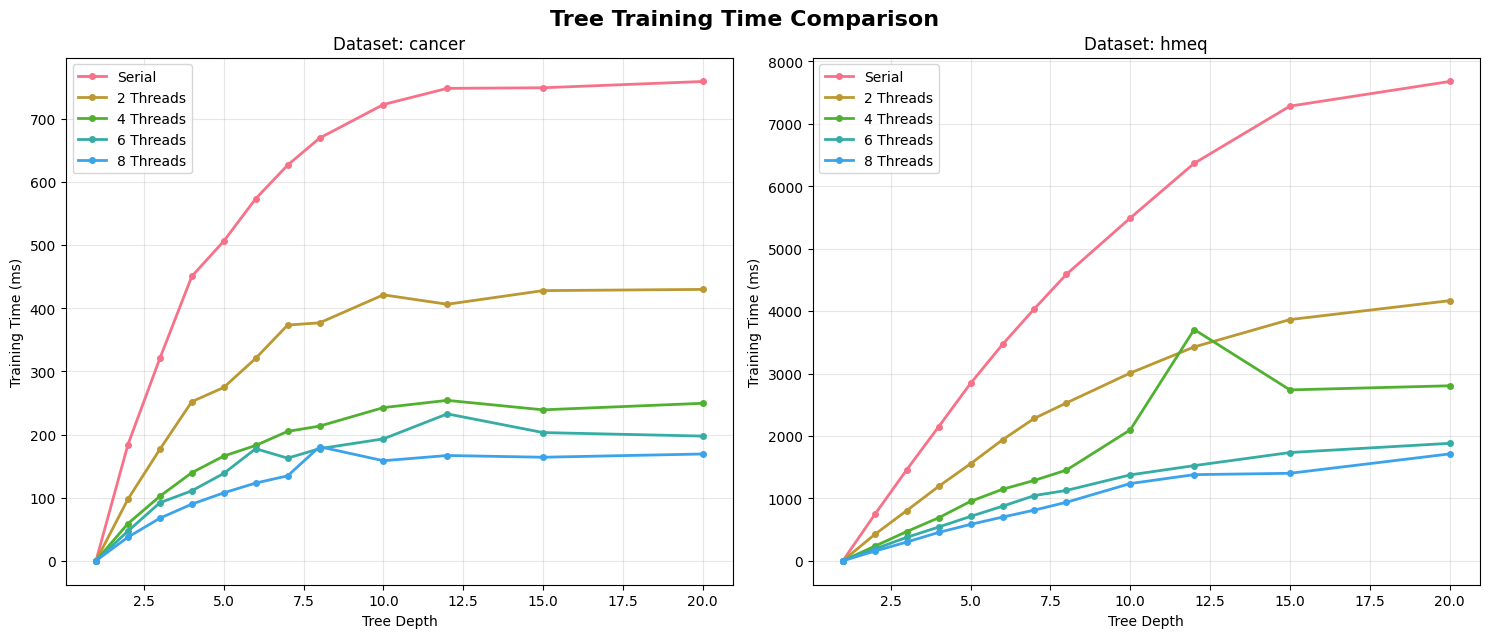

  ✓ Tree training time comparison saved


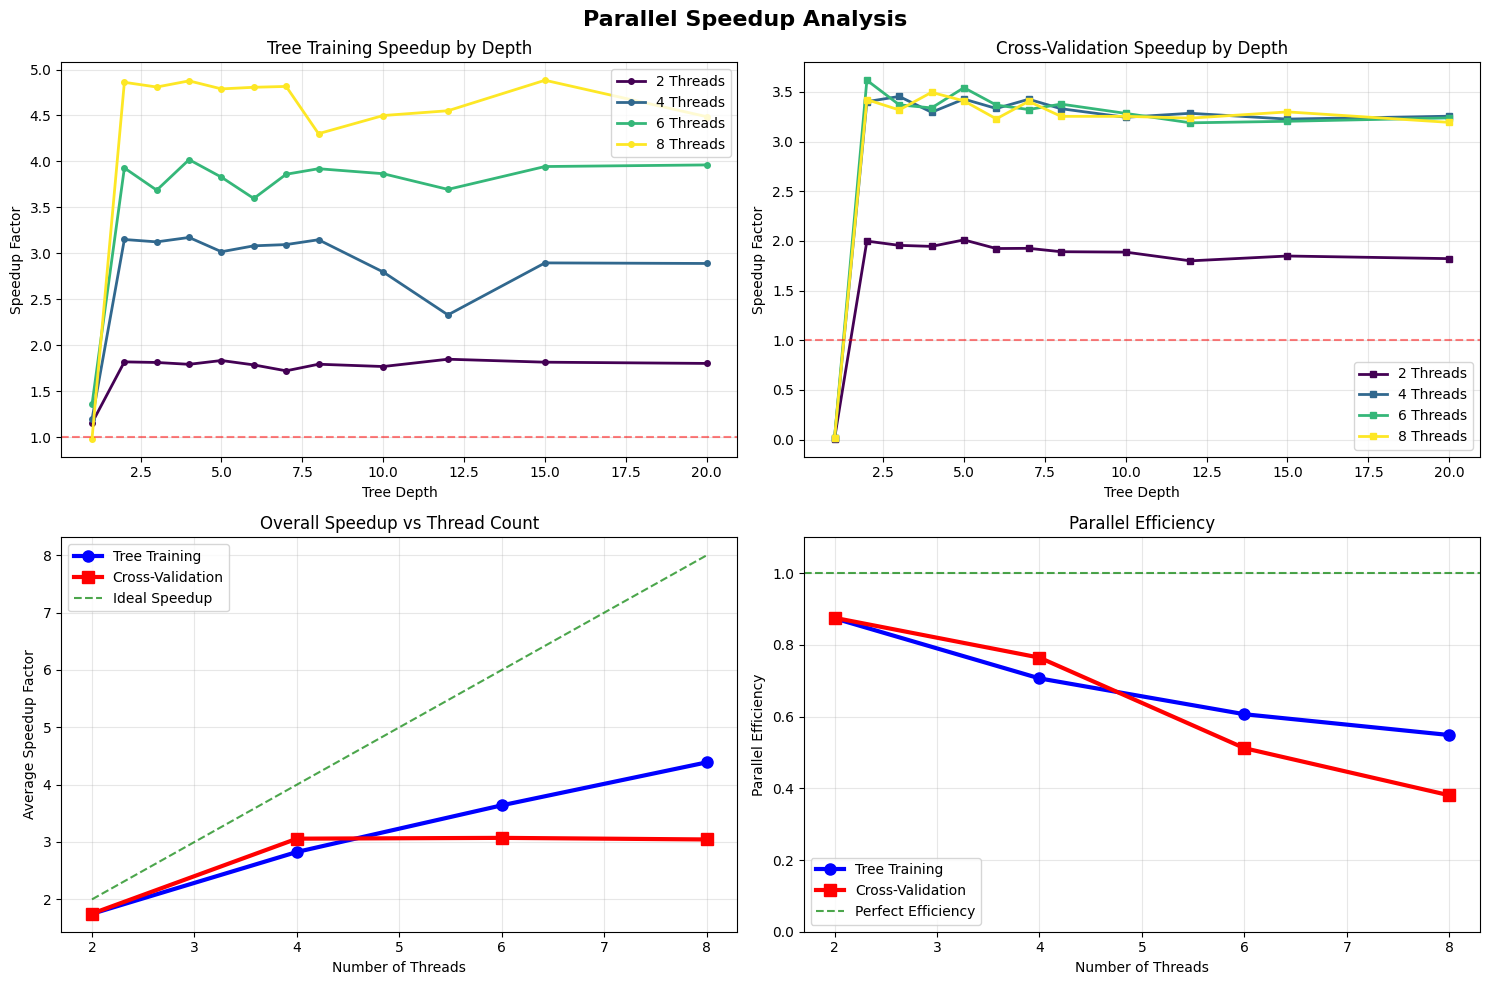

  ✓ Speedup analysis saved

PERFORMANCE SUMMARY

🌳 TREE TRAINING PERFORMANCE:
----------------------------------------
Serial - Avg time: 2184.1ms (range: 0.0-7678.1ms)
2threads  - Avg time: 1197.7ms, Speedup: 1.82x
4threads  - Avg time: 817.7ms, Speedup: 2.67x
6threads  - Avg time: 546.2ms, Speedup: 4.00x
8threads  - Avg time: 461.2ms, Speedup: 4.74x

🔄 CROSS-VALIDATION PERFORMANCE:
----------------------------------------
Serial - Avg time: 8430.8ms (range: 0.1-29346.7ms)
2threads  - Avg time: 4475.4ms, Speedup: 1.88x
4threads  - Avg time: 2575.7ms, Speedup: 3.27x
6threads  - Avg time: 2543.1ms, Speedup: 3.32x
8threads  - Avg time: 2537.9ms, Speedup: 3.32x

🏆 OPTIMAL CONFIGURATIONS:
----------------------------------------
Best tree training: 8threads (4.74x speedup)
Best cross-validation: 8threads (3.32x speedup)

🎉 Analysis complete!

Generated files:
  • tree_training_time_comparison.png
  • speedup_analysis.png


In [25]:
#!/usr/bin/env python3
"""
Benchmark Analysis and Visualization Script
Analyzes tree training and cross-validation performance across different thread counts
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def load_benchmark_data():
    """Load all benchmark CSV files"""
    data = {}
    
    # Define file patterns
    tree_files = {
        'serial': 'benchmark_results_serial.csv',
        '2threads': 'benchmark_results_parallel_2threads.csv',
        '4threads': 'benchmark_results_parallel_4threads.csv',
        '6threads': 'benchmark_results_parallel_6threads.csv',
        '8threads': 'benchmark_results_parallel_8threads.csv'
    }
    
    cv_files = {
        'serial': 'cv_results_serial.csv',
        '2threads': 'cv_results_parallel_2threads.csv',
        '4threads': 'cv_results_parallel_4threads.csv',
        '6threads': 'cv_results_parallel_6threads.csv',
        '8threads': 'cv_results_parallel_8threads.csv'
    }
    
    # Load tree benchmark data
    print("Loading tree benchmark data...")
    data['tree'] = {}
    for config, filename in tree_files.items():
        try:
            df = pd.read_csv(filename)
            data['tree'][config] = df
            print(f"  ✓ Loaded {filename}: {len(df)} rows")
        except FileNotFoundError:
            print(f"  ✗ Missing {filename}")
        except Exception as e:
            print(f"  ✗ Error loading {filename}: {e}")
    
    # Load CV data
    print("\nLoading cross-validation data...")
    data['cv'] = {}
    for config, filename in cv_files.items():
        try:
            df = pd.read_csv(filename)
            data['cv'][config] = df
            print(f"  ✓ Loaded {filename}: {len(df)} rows")
        except FileNotFoundError:
            print(f"  ✗ Missing {filename}")
        except Exception as e:
            print(f"  ✗ Error loading {filename}: {e}")
    
    return data

def calculate_speedup(data_dict, time_column):
    """Calculate speedup relative to serial version"""
    if 'serial' not in data_dict:
        return {}
    
    serial_data = data_dict['serial']
    speedup_data = {}
    
    for config, df in data_dict.items():
        if config == 'serial':
            continue
            
        speedup_df = df.copy()
        speedup_df['speedup'] = 0.0
        
        for dataset in df['dataset'].unique():
            for depth in df['max_depth'].unique():
                # Get serial time for this dataset/depth
                serial_time = serial_data[
                    (serial_data['dataset'] == dataset) & 
                    (serial_data['max_depth'] == depth)
                ][time_column].values
                
                # Get parallel time for this dataset/depth
                parallel_time = df[
                    (df['dataset'] == dataset) & 
                    (df['max_depth'] == depth)
                ][time_column].values
                
                if len(serial_time) > 0 and len(parallel_time) > 0:
                    speedup = serial_time[0] / parallel_time[0]
                    mask = (speedup_df['dataset'] == dataset) & (speedup_df['max_depth'] == depth)
                    speedup_df.loc[mask, 'speedup'] = speedup
        
        speedup_data[config] = speedup_df
    
    return speedup_data

def plot_training_time_comparison(tree_data):
    """Plot tree training time comparison across thread counts"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Tree Training Time Comparison', fontsize=16, fontweight='bold')
    
    datasets = list(tree_data['serial']['dataset'].unique())
    thread_configs = ['serial', '2threads', '4threads', '6threads', '8threads']
    thread_labels = ['Serial', '2 Threads', '4 Threads', '6 Threads', '8 Threads']
    
    for i, dataset in enumerate(datasets):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        for j, (config, label) in enumerate(zip(thread_configs, thread_labels)):
            if config in tree_data:
                data = tree_data[config][tree_data[config]['dataset'] == dataset]
                ax.plot(data['max_depth'], data['train_time_ms'], 
                       marker='o', label=label, linewidth=2, markersize=4)
        
        ax.set_xlabel('Tree Depth')
        ax.set_ylabel('Training Time (ms)')
        ax.set_title(f'Dataset: {dataset}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots if less than 4 datasets
    for i in range(len(datasets), 4):
        row, col = i // 2, i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('tree_training_time_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_speedup_analysis(tree_data, cv_data):
    """Plot speedup analysis for both tree training and CV"""
    # Calculate speedups
    tree_speedup = calculate_speedup(tree_data, 'train_time_ms')
    cv_speedup = calculate_speedup(cv_data, 'cv_training_time_ms')
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Parallel Speedup Analysis', fontsize=16, fontweight='bold')
    
    thread_configs = ['2threads', '4threads', '6threads', '8threads']
    thread_numbers = [2, 4, 6, 8]
    colors = plt.cm.viridis(np.linspace(0, 1, len(thread_configs)))
    
    # Tree training speedup by depth
    ax = axes[0, 0]
    for config, color in zip(thread_configs, colors):
        if config in tree_speedup:
            data = tree_speedup[config]
            avg_speedup = data.groupby('max_depth')['speedup'].mean()
            ax.plot(avg_speedup.index, avg_speedup.values, 
                   marker='o', label=f'{config.replace("threads", " Threads")}', 
                   color=color, linewidth=2, markersize=4)
    
    ax.set_xlabel('Tree Depth')
    ax.set_ylabel('Speedup Factor')
    ax.set_title('Tree Training Speedup by Depth')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
    
    # CV speedup by depth
    ax = axes[0, 1]
    for config, color in zip(thread_configs, colors):
        if config in cv_speedup:
            data = cv_speedup[config]
            avg_speedup = data.groupby('max_depth')['speedup'].mean()
            ax.plot(avg_speedup.index, avg_speedup.values, 
                   marker='s', label=f'{config.replace("threads", " Threads")}', 
                   color=color, linewidth=2, markersize=4)
    
    ax.set_xlabel('Tree Depth')
    ax.set_ylabel('Speedup Factor')
    ax.set_title('Cross-Validation Speedup by Depth')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
    
    # Overall speedup vs thread count
    ax = axes[1, 0]
    tree_avg_speedup = []
    cv_avg_speedup = []
    
    for config in thread_configs:
        if config in tree_speedup:
            tree_avg_speedup.append(tree_speedup[config]['speedup'].mean())
        else:
            tree_avg_speedup.append(0)
            
        if config in cv_speedup:
            cv_avg_speedup.append(cv_speedup[config]['speedup'].mean())
        else:
            cv_avg_speedup.append(0)
    
    ax.plot(thread_numbers, tree_avg_speedup, marker='o', label='Tree Training', 
            linewidth=3, markersize=8, color='blue')
    ax.plot(thread_numbers, cv_avg_speedup, marker='s', label='Cross-Validation', 
            linewidth=3, markersize=8, color='red')
    ax.plot(thread_numbers, thread_numbers, linestyle='--', color='green', 
            alpha=0.7, label='Ideal Speedup')
    
    ax.set_xlabel('Number of Threads')
    ax.set_ylabel('Average Speedup Factor')
    ax.set_title('Overall Speedup vs Thread Count')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Parallel efficiency
    ax = axes[1, 1]
    tree_efficiency = [s/t for s, t in zip(tree_avg_speedup, thread_numbers)]
    cv_efficiency = [s/t for s, t in zip(cv_avg_speedup, thread_numbers)]
    
    ax.plot(thread_numbers, tree_efficiency, marker='o', label='Tree Training', 
            linewidth=3, markersize=8, color='blue')
    ax.plot(thread_numbers, cv_efficiency, marker='s', label='Cross-Validation', 
            linewidth=3, markersize=8, color='red')
    ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Efficiency')
    
    ax.set_xlabel('Number of Threads')
    ax.set_ylabel('Parallel Efficiency')
    ax.set_title('Parallel Efficiency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()



def print_performance_summary(tree_data, cv_data):
    """Print summary statistics"""
    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    
    # Tree training summary
    print("\n🌳 TREE TRAINING PERFORMANCE:")
    print("-" * 40)
    
    if 'serial' in tree_data:
        serial_times = tree_data['serial']['train_time_ms']
        print(f"Serial - Avg time: {serial_times.mean():.1f}ms (range: {serial_times.min():.1f}-{serial_times.max():.1f}ms)")
    
    for config in ['2threads', '4threads', '6threads', '8threads']:
        if config in tree_data:
            times = tree_data[config]['train_time_ms']
            if 'serial' in tree_data:
                serial_avg = tree_data['serial']['train_time_ms'].mean()
                speedup = serial_avg / times.mean()
                print(f"{config:<9} - Avg time: {times.mean():.1f}ms, Speedup: {speedup:.2f}x")
            else:
                print(f"{config:<9} - Avg time: {times.mean():.1f}ms")
    
    # CV summary
    print("\n🔄 CROSS-VALIDATION PERFORMANCE:")
    print("-" * 40)
    
    if 'serial' in cv_data:
        serial_times = cv_data['serial']['cv_training_time_ms']
        print(f"Serial - Avg time: {serial_times.mean():.1f}ms (range: {serial_times.min():.1f}-{serial_times.max():.1f}ms)")
    
    for config in ['2threads', '4threads', '6threads', '8threads']:
        if config in cv_data:
            times = cv_data[config]['cv_training_time_ms']
            if 'serial' in cv_data:
                serial_avg = cv_data['serial']['cv_training_time_ms'].mean()
                speedup = serial_avg / times.mean()
                print(f"{config:<9} - Avg time: {times.mean():.1f}ms, Speedup: {speedup:.2f}x")
            else:
                print(f"{config:<9} - Avg time: {times.mean():.1f}ms")
    
    # Best configurations
    print("\n🏆 OPTIMAL CONFIGURATIONS:")
    print("-" * 40)
    
    # Find best speedup for tree training
    best_tree_speedup = 0
    best_tree_config = "serial"
    if 'serial' in tree_data:
        serial_avg = tree_data['serial']['train_time_ms'].mean()
        for config in ['2threads', '4threads', '6threads', '8threads']:
            if config in tree_data:
                parallel_avg = tree_data[config]['train_time_ms'].mean()
                speedup = serial_avg / parallel_avg
                if speedup > best_tree_speedup:
                    best_tree_speedup = speedup
                    best_tree_config = config
    
    print(f"Best tree training: {best_tree_config} ({best_tree_speedup:.2f}x speedup)")
    
    # Find best speedup for CV
    best_cv_speedup = 0
    best_cv_config = "serial"
    if 'serial' in cv_data:
        serial_avg = cv_data['serial']['cv_training_time_ms'].mean()
        for config in ['2threads', '4threads', '6threads', '8threads']:
            if config in cv_data:
                parallel_avg = cv_data[config]['cv_training_time_ms'].mean()
                speedup = serial_avg / parallel_avg
                if speedup > best_cv_speedup:
                    best_cv_speedup = speedup
                    best_cv_config = config
    
    print(f"Best cross-validation: {best_cv_config} ({best_cv_speedup:.2f}x speedup)")

def main():
    """Main analysis function"""
    print("🚀 Starting Benchmark Analysis...")
    print("="*50)
    
    # Load data
    data = load_benchmark_data()
    
    if not data['tree'] or not data['cv']:
        print("❌ Could not load benchmark data. Please ensure CSV files are in the current directory.")
        return
    
    print(f"\n✅ Loaded data for {len(data['tree'])} tree configurations and {len(data['cv'])} CV configurations")
    
    # Generate plots
    print("\n📊 Generating visualizations...")
    
    try:
        plot_training_time_comparison(data['tree'])
        print("  ✓ Tree training time comparison saved")
        
        plot_speedup_analysis(data['tree'], data['cv'])
        print("  ✓ Speedup analysis saved")
        
    except Exception as e:
        print(f"  ❌ Error generating plots: {e}")
    
    # Print summary
    print_performance_summary(data['tree'], data['cv'])
    
    print("\n🎉 Analysis complete!")
    print("\nGenerated files:")
    print("  • tree_training_time_comparison.png")
    print("  • speedup_analysis.png")

if __name__ == "__main__":
    main()